In [41]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [42]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [43]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [44]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [45]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [46]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [47]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [48]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [49]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [50]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [51]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [52]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [53]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040668,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,0.7776,34.071129,NaN
2017-01-04,3.572773,0.234935,2.845574,5.016480,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,0.7788,34.166381,0.002796
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305233,0.7452,34.106142,-0.001763
2017-01-06,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.427286,0.372564,0.244542,0.146038,0.885082,6.259279,0.7688,34.345450,0.007017
2017-01-09,3.466946,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227232,0.7524,34.208485,-0.003988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.461538,1.887081,15.755003,23.018518,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,0.1456,121.609696,0.006748
2020-12-28,5.479294,1.882765,15.635185,22.882718,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858301,0.1456,120.750231,-0.007067
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,11.509844,3.130025,0.868532,0.310156,0.272726,1.761936,16.843045,0.1512,120.867053,0.000967


## Get old data for portfolio

In [54]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040668,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,0.7776,34.071129,NaN
2017-01-04,3.572773,0.234935,2.845574,5.016480,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,0.7788,34.166381,0.002796
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305233,0.7452,34.106142,-0.001763
2017-01-06,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.427286,0.372564,0.244542,0.146038,0.885082,6.259279,0.7688,34.345450,0.007017
2017-01-09,3.466946,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227232,0.7524,34.208485,-0.003988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.461538,1.887081,15.755003,23.018518,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,0.1456,121.609696,0.006748
2020-12-28,5.479294,1.882765,15.635185,22.882718,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858301,0.1456,120.750231,-0.007067
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,11.509844,3.130025,0.868532,0.310156,0.272726,1.761936,16.843045,0.1512,120.867053,0.000967


## Forecasting

In [55]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [56]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [57]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040668,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,0.7776,34.071129,NaN
2017-01-04,3.572773,0.234935,2.845574,5.016480,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,0.7788,34.166381,0.002796
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305233,0.7452,34.106142,-0.001763
2017-01-06,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.427286,0.372564,0.244542,0.146038,0.885082,6.259279,0.7688,34.345450,0.007017
2017-01-07,3.571798,0.232674,2.956550,5.071245,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,2.015532,1.427286,0.372564,0.244542,0.146038,0.885082,6.259279,0.7688,34.345450,0.007017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,5.461538,1.887081,15.755003,23.018518,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,0.1456,121.609696,0.006748
2020-12-28,5.479294,1.882765,15.635185,22.882718,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858301,0.1456,120.750231,-0.007067
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,11.509844,3.130025,0.868532,0.310156,0.272726,1.761936,16.843045,0.1512,120.867053,0.000967


In [58]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [59]:
tot_port_df

,Total
Date,
2017-01-03,34.071129
2017-01-04,34.166381
2017-01-05,34.106142
2017-01-06,34.345450
2017-01-07,34.345450
...,...
2020-12-27,121.609696
2020-12-28,120.750231
2020-12-29,120.867053


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Observations : 1459


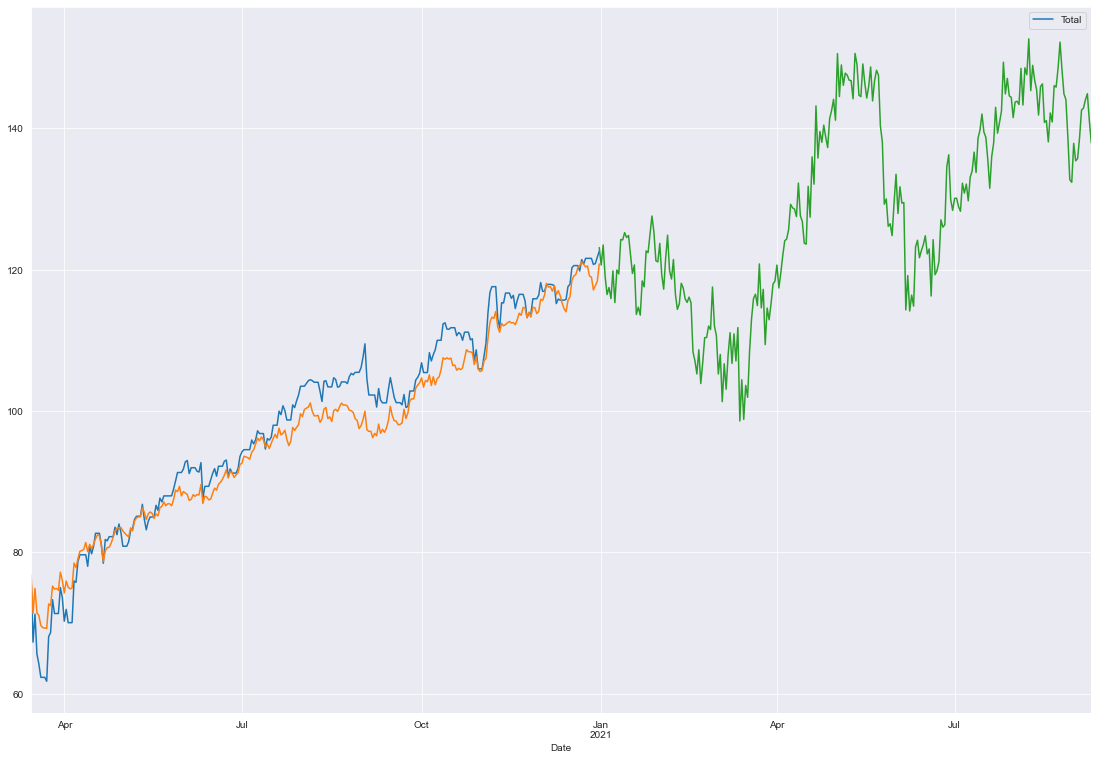

In [60]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [61]:
forecast

2020-12-31    123.132145
2021-01-01    120.663197
2021-01-02    123.506900
2021-01-03    119.074117
2021-01-04    116.493619
                 ...    
2021-09-05    142.857926
2021-09-06    144.036779
2021-09-07    144.904144
2021-09-08    141.147737
2021-09-09    137.967680
Freq: D, Length: 253, dtype: float64

In [62]:
forecast_df = pd.DataFrame(forecast)

In [63]:
forecast_df

,0
2020-12-31,123.132145
2021-01-01,120.663197
2021-01-02,123.506900
2021-01-03,119.074117
2021-01-04,116.493619
...,...
2021-09-05,142.857926
2021-09-06,144.036779
2021-09-07,144.904144
2021-09-08,141.147737


In [64]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [65]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.020051
2021-01-02,0.003044
2021-01-03,-0.032957
2021-01-04,-0.053914
...,...
2021-09-05,0.160200
2021-09-06,0.169774
2021-09-07,0.176818
2021-09-08,0.146311


In [66]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  12.048466


## Backtesting

In [73]:
tickers2 = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [74]:
panel_data2 = panel_data2['Adj Close']

In [75]:
panel_data2

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,94.166412,92.290001,358.480011,487.229980,26.848875,58.139999,15.175845,27.559999,496.959991,177.520004,...,137.860001,137.899994,189.139999,142.749695,30.581203,16.510559,13.570000,62.400002,271.858215,0.370
2020-12-31,95.311989,91.709999,358.350006,485.051971,26.616995,58.480000,15.098663,27.750000,499.869995,179.169998,...,139.199997,138.630005,191.630005,144.477051,30.600670,16.862049,13.650000,62.720001,279.353760,0.361
2021-01-04,93.564987,92.300003,348.059998,497.264771,26.462418,57.730000,14.432972,27.280001,491.769989,176.600006,...,134.419998,141.360001,190.660004,140.945984,30.279478,16.938044,13.550000,59.500000,272.917725,0.354
2021-01-05,92.314400,92.769997,345.700012,502.595459,27.728052,58.820000,14.375086,27.350000,497.260010,179.339996,...,133.990005,145.679993,194.669998,142.282059,30.600670,16.890549,13.620000,59.419998,269.897705,0.377
2021-01-06,93.775017,90.330002,329.660004,487.538300,27.728052,57.200001,14.124246,27.400000,483.600006,186.250000,...,139.880005,155.580002,197.009995,144.610657,30.201614,16.748049,14.940000,60.610001,262.035889,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,109.092499,146.139999,663.080017,801.409973,33.800323,80.900002,20.666519,38.340000,645.020020,278.010010,...,223.369995,152.139999,264.649994,193.571014,55.196152,24.795002,24.820000,105.820000,373.462097,1.243
2021-12-27,109.825798,154.360001,697.000000,811.429993,34.402489,81.820000,21.160698,40.820000,654.840027,282.059998,...,227.899994,151.100006,267.859985,197.565552,55.852657,24.579479,25.389999,107.790001,382.522247,1.252
2021-12-28,110.876190,153.149994,682.200012,804.770020,34.165573,82.000000,20.824657,40.430000,651.280029,280.609985,...,218.300003,149.979996,253.770004,197.654755,55.176258,24.520700,25.049999,107.720001,383.889252,1.245


## Portfolio Analysis

In [76]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.012165,-0.006285,-0.000363,-0.004470,-0.008636,0.005848,-0.005086,0.006894,0.005856,0.009295,...,0.009720,0.005294,0.013165,0.012101,0.000637,0.021289,0.005895,0.005128,0.027572,-0.024324
2021-01-04,-0.018329,0.006433,-0.028715,0.025178,-0.005807,-0.012825,-0.044089,-0.016937,-0.016204,-0.014344,...,-0.034339,0.019693,-0.005062,-0.024440,-0.010496,0.004507,-0.007326,-0.051339,-0.023039,-0.019391
2021-01-05,-0.013366,0.005092,-0.006780,0.010720,0.047828,0.018881,-0.004011,0.002566,0.011164,0.015515,...,-0.003199,0.030560,0.021032,0.009479,0.010608,-0.002804,0.005166,-0.001345,-0.011066,0.064972
2021-01-06,0.015822,-0.026302,-0.046399,-0.029959,0.000000,-0.027542,-0.017450,0.001828,-0.027471,0.038530,...,0.043958,0.067957,0.012020,0.016366,-0.013041,-0.008437,0.096916,0.020027,-0.029129,0.145889
2021-01-07,-0.034511,0.053471,0.026755,0.022867,0.018467,0.024475,0.019126,0.015328,0.023966,0.009718,...,0.000143,0.046150,0.035937,0.019930,0.014180,0.044243,0.017403,0.014684,0.002305,0.050926


In [77]:
portfolio_weights = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000730,-0.000129,-0.000016,-0.000214,-0.000247,0.000155,-0.000053,0.000013,0.000363,0.000017,...,0.000142,0.000089,0.000802,0.000267,0.000018,0.000404,0.000120,0.000145,0.001699,-0.009730
2021-01-04,-0.001100,0.000132,-0.001270,0.001206,-0.000166,-0.000340,-0.000455,-0.000031,-0.001004,-0.000027,...,-0.000501,0.000331,-0.000308,-0.000540,-0.000300,0.000086,-0.000149,-0.001456,-0.001420,-0.007756
2021-01-05,-0.000802,0.000105,-0.000300,0.000514,0.001370,0.000501,-0.000041,0.000005,0.000692,0.000029,...,-0.000047,0.000514,0.001281,0.000210,0.000303,-0.000053,0.000105,-0.000038,-0.000682,0.025989
2021-01-06,0.000949,-0.000541,-0.002051,-0.001435,0.000000,-0.000731,-0.000180,0.000003,-0.001702,0.000072,...,0.000641,0.001142,0.000732,0.000362,-0.000372,-0.000160,0.001974,0.000568,-0.001795,0.058355
2021-01-07,-0.002071,0.001099,0.001183,0.001096,0.000529,0.000649,0.000198,0.000028,0.001485,0.000018,...,0.000002,0.000775,0.002188,0.000441,0.000405,0.000840,0.000354,0.000417,0.000142,0.020370


In [78]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.005553
2021-01-04   -0.014972
2021-01-05    0.030307
2021-01-06    0.056568
2021-01-07    0.031399
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,124.1%
Cumulative returns,124.1%
Annual volatility,30.3%
Sharpe ratio,2.82
Calmar ratio,11.61
Stability,0.90
Max drawdown,-10.7%


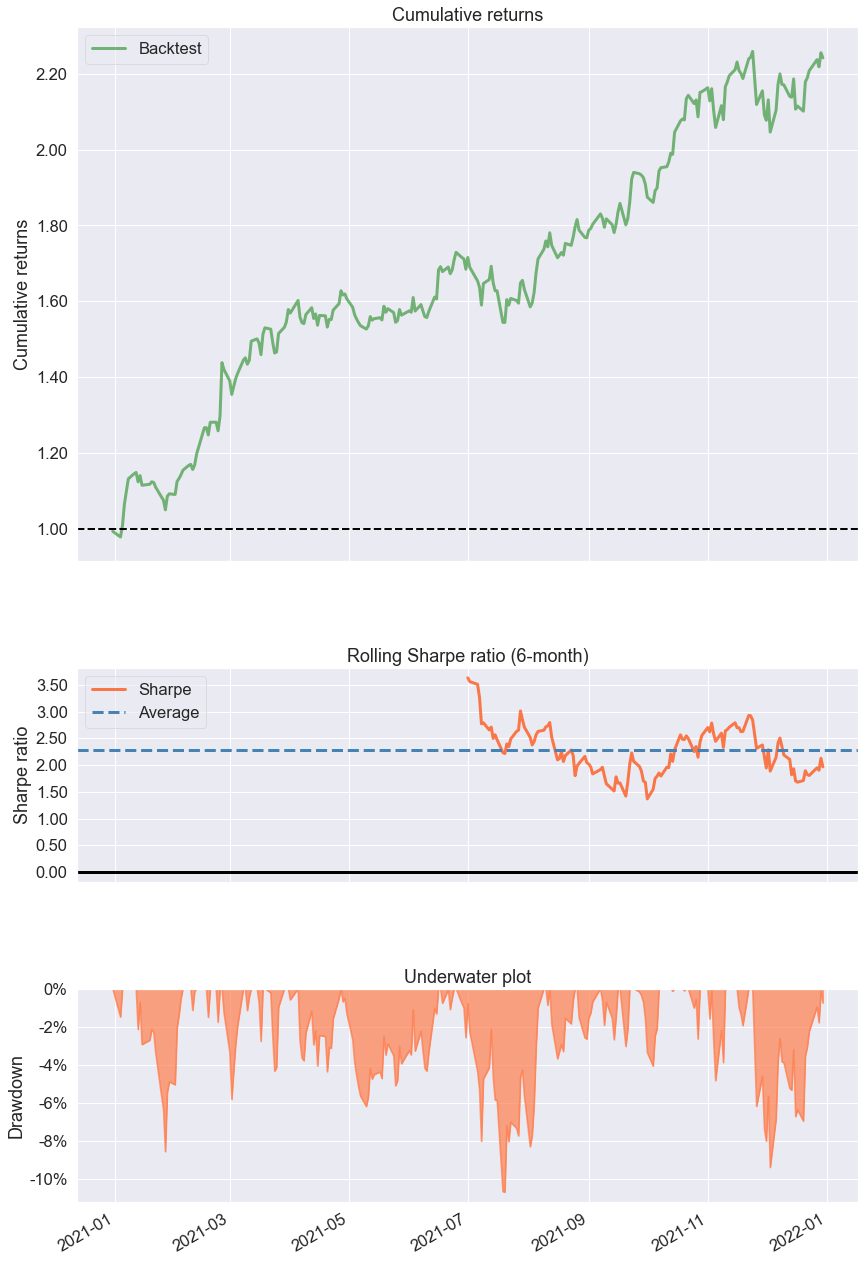

In [79]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [ ]:
import itertools

In [ ]:
weights = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

In [ ]:
panel_data2 = panel_data2 * weights

In [ ]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [ ]:
#forecasted portfolio value
panel_data2

In [ ]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [ ]:
actual_portfolio_value

In [ ]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [ ]:
forecasted_portfolio_value

## Calculate MAPE of forecasted period

In [ ]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')

## Mean Squared Error

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

## Forecast for future

In [ ]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "LULU"]

#add in the weightage of stocks
port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632,0.4]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

In [ ]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

In [ ]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

In [ ]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [ ]:
tot_port_df

In [ ]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [ ]:
tot_port_df

In [ ]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [ ]:
## Calculate annualized returns for forecasted

In [ ]:
forecast

In [ ]:
forecast_df = pd.DataFrame(forecast)

In [ ]:
forecast_df

In [ ]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [ ]:
return_series

In [ ]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)